# Quantile Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp 

import lightgbm as lgb

## Gen Data

In [2]:

def pendulum_actual(t, state, p):
    # state = [theta, theta_d]

    # Parameters
    mu, L = p

    # Calc derivatives
    theta_d = state[1]
    theta_dd = 9.8 * np.sin(state[0]) / L - mu * state[1]

    return np.array([theta_d, theta_dd])

# Set initial conditions and parameters
tspan = (0, 20)
X0 = np.array([0.524, 0.0])  # 30 degrees, at rest
p = [0.2, 1.0]

# solve ODE
t = np.linspace(*tspan, 100)
res = solve_ivp(pendulum_actual, tspan, X0, args=[p], dense_output=True)
X = res.y.T


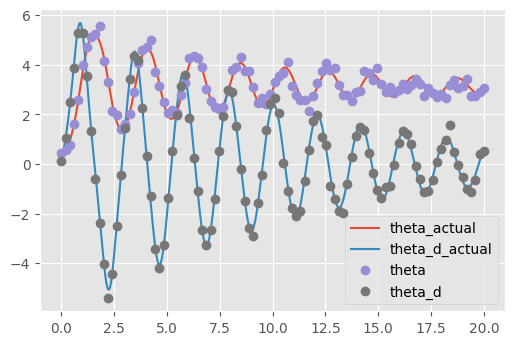

In [3]:
plt.style.use("ggplot")

all_t = np.linspace(*tspan, 1000)
fig, ax = plt.subplots(dpi=100)
pd.DataFrame(
    res.sol(all_t).T, index=all_t, columns=["theta_actual", "theta_d_actual"]
).plot(ax=ax)

t = np.linspace(*tspan, 100)
data = pd.DataFrame(
    res.sol(t).T + 0.2 * np.random.normal(size=(t.shape[0], 2)),
    index=t,
    columns=["theta", "theta_d"],
)
data.plot(ax=ax, ls="", marker="o")

plt.show()


In [4]:
# Get theta_dd
data["theta_dd"] = data.apply(lambda row: pendulum_actual(0, [row.theta, row.theta_d], p)[1], axis=1)

data

,theta,theta_d,theta_dd
0.000000,0.440049,0.126341,4.149370
0.202020,0.581161,1.039303,5.172289
0.404040,0.754109,2.516183,6.206233
0.606061,1.593960,3.849287,9.027514
0.808081,2.580472,5.279365,4.159050
...,...,...,...
19.191919,3.411106,-1.003255,-2.408720
19.393939,2.741355,-1.129858,4.044419
19.595960,2.741486,-0.631111,3.943481
19.797980,2.886499,0.403734,2.392142


## Model theta_dd

How would this look?

* Class that takes in a set of quantiles and fits set of regressors
* I think it will require some form of simulation to be useful
    * How else can uncertainty be propagated through?
* How can quantiles be used to simulate?
    * Non-parametric
        * estimate a bunch of quantiles
        * use a step distribution
        * dealing with the tails
          * set some arbitrary boundary past the last quantile
          * Estimate a very high quantile, like 99.9%, and assume there's nothing past that
    * Parametric
        * estimate a bunch of quantiles
        * Pick a distribution type (normal?)
        * Fit distribution to quantiles
            * MLE fitting
            * Estimate 1 SD above/below and average


I see benefits and drawbacks to both of these approaches. For the non-parametric, we have the freedom to approximate any shape of distribution, but the more accuracy we want, the more models we'll have to include. However, maybe this isn't terrible, since the prediction is what will be happening every go-round. Parametric seems cleaner at first, but it seems like a big assumption that everything will have the same distributional form.

In [5]:
from typing import Any
from sklearn.base import clone
from bisect import bisect
import numpy as np
from lightgbm import LGBMRegressor


class QuantileRegressor:

    def __init__(self, base_model: Any, quantiles: list[float], sample: bool = False, random_state = None) -> None:
        self.base_model = base_model
        self.quantiles = list(sorted(quantiles))
        self.sample = sample
        self.rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        self.models = {}

        # Create additional features
        X["sin_theta"] = np.sin(X["theta"])
        X["cos_theta"] = np.cos(X["theta"])

        # Fit quantile regressors
        for q in self.quantiles:
            # Copy and define model
            params = {
                "objective": "quantile",
                "alpha": q,
            }
            model = clone(self.base_model)
            model.set_params(**params)

            # Fit and save model
            model.fit(X, y)
            self.models[q] = model


    def predict(self, X, single_row: bool=False):
        # Add additional features
        X = np.hstack((X, np.sin(X[:, 0]).reshape(-1, 1), np.cos(X[:, 0]).reshape(-1, 1)))

        preds = [mod.predict(X) for _, mod in self.models.items()]
        if single_row:
            preds = [p[0] for p in preds]
        return preds

    
    def sol_fn(self, t: float, X0: np.ndarray):
        if self.sample:
            runif = self.rng.uniform()
        else:
            runif = 0.5
        
        if len(X0.shape) == 1:
            X0 = X0.reshape(1, -1)
        return [X0[0, 1], self.np_sample_from_quantiles(self.predict(X0, single_row = True), runif)]

    
    def np_sample_from_quantiles(self, q_vals: list[float], runif: float):
        # Get densities
        densities = []
        for i in range(len(q_vals) - 1):
            # Get quantile percent values
            q1 = self.quantiles[i]
            q2 = self.quantiles[i + 1]

            # Save density
            densities.append((q2 - q1) / (q_vals[i + 1] - q_vals[i]))
        
        # Add min
        d_mult = 0.5
        q1 = self.quantiles[0]
        qmin = q_vals[0] - q1 / (d_mult * densities[0])

        # Add max
        d_mult = 0.5
        q1 = self.quantiles[-1]
        qmax = q_vals[-1] + (1 - q1) / (d_mult * densities[-1])
        
        # Add edge values
        q_vals = [qmin] + q_vals + [qmax]
        quantiles = [0] + list(self.quantiles) + [1]
        densities = [0, self.quantiles[0] / (q_vals[1] - q_vals[0])] + densities + [(1 - self.quantiles[-1]) / (q_vals[-1] - q_vals[-2]), 0]
        
        # Sample
        idx = min(bisect(quantiles, runif), len(quantiles)-1)
        min_val, max_val = q_vals[idx - 1], q_vals[idx]
        lower_dens, higher_dens = densities[idx - 1], densities[idx + 1]

        avg_dens = (higher_dens + lower_dens) / 2
        f_a = lower_dens / avg_dens * densities[idx]
        f_b = higher_dens / avg_dens * densities[idx]
        A = (f_b - f_a) / (max_val - min_val)

        res1 = (-f_a + np.sqrt(f_a**2 - 2 * A * (quantiles[idx - 1] - runif))) / A + min_val

        return res1


In [18]:
quantiles = [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995]
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
qr = QuantileRegressor(LGBMRegressor(), quantiles=quantiles, sample=True, random_state=5)
qr.fit(data.drop(columns="theta_dd"), data.theta_dd)

In [24]:
X0 = data.drop(columns="theta_dd").iloc[0].to_numpy()#.reshape(1, -1)
X0

array([0.44004862, 0.12634142])

In [41]:
res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 45854
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000019E198735B0>
   status: 0
  success: True
        t: array([0.00000000e+00, 6.60917265e-04, 1.17774338e-03, ...,
       1.99955272e+01, 1.99981141e+01, 2.00000000e+01])
 t_events: None
        y: array([[0.44004862, 0.44013395, 0.44020276, ..., 3.69656692, 3.69808141,
        3.69916172],
       [0.12634142, 0.1314982 , 0.13502012, ..., 0.59185881, 0.57811999,
        0.56739112]])
 y_events: None

In [40]:
%%time
res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), dense_output=True, method="RK23")

CPU times: total: 6min 15s
Wall time: 2min 14s


In [42]:
%%time
res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), dense_output=True, method="Radau")

CPU times: total: 609 ms
Wall time: 172 ms


In [43]:
res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 114
     njev: 1
      nlu: 28
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000019E115082B0>
   status: 0
  success: True
        t: array([0.00000000e+00, 3.70757085e-03, 4.07832793e-02, 2.56364670e-01,
       4.71946061e-01, 7.33017397e-01, 9.94088734e-01, 1.33936520e+00,
       1.77601676e+00, 2.35195151e+00, 3.13409349e+00, 4.22566485e+00,
       5.80031667e+00, 8.17895275e+00, 1.20344859e+01, 1.90866424e+01,
       2.00000000e+01])
 t_events: None
        y: array([[4.40048619e-01, 4.40516722e-01, 4.45164867e-01, 4.74103371e-01,
        5.30785823e-01, 7.28054282e-01, 1.23413774e+00, 2.79506622e+00,
        7.28291448e+00, 2.04344928e+01, 6.01002587e+01, 1.84522364e+02,
        5.96933880e+02, 2.07968003e+03, 8.14280410e+03, 3.93256646e+04,
        4.59813588e+04],
       [1.26341419e-01, 1.26171005e-01, 1.24654926e-01, 1.64116536e-01,
        4.09929403e-01, 1.21356154

In [44]:
%%time
res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), dense_output=True, method="BDF")

CPU times: total: 375 ms
Wall time: 138 ms


In [45]:

res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 68
     njev: 2
      nlu: 12
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x0000019E198739A0>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.34322380e-05, 2.68644759e-05, 1.61186856e-04,
       2.95509235e-04, 1.63873303e-03, 2.98195683e-03, 1.64141948e-02,
       2.98464328e-02, 4.32786707e-02, 1.36424759e-01, 2.29570847e-01,
       3.22716935e-01, 5.18010605e-01, 7.13304274e-01, 9.08597944e-01,
       1.10389161e+00, 1.57086233e+00, 2.03783305e+00, 2.50480377e+00,
       2.97177449e+00, 4.03605834e+00, 5.10034219e+00, 6.16462605e+00,
       7.22890990e+00, 8.29319375e+00, 9.84425528e+00, 1.13953168e+01,
       1.29463783e+01, 1.44974399e+01, 1.60485014e+01, 1.85113102e+01,
       2.00000000e+01])
 t_events: None
        y: array([[4.40048619e-01, 4.40050317e-01, 4.40052016e-01, 4.40069113e-01,
        4.40086330e-01, 4.40268956e-01, 4.40463488e-01, 4.430556

In [36]:
%%time
res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), dense_output=True, method="LSODA")

CPU times: total: 2.75 s
Wall time: 1.18 s


In [37]:
from tqdm import tqdm


nsims = 10
nt = 1000
all_t = np.linspace(*tspan, nt)

theta_sims = np.zeros((nt, nsims))
theta_d_sims = np.zeros((nt, nsims))
for i in tqdm(range(nsims)):
    res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), dense_output=True, method="LSODA")
    curr_sol = res.sol(all_t).T
    # res = solve_ivp(qr.sol_fn, tspan, data.drop(columns="theta_dd").iloc[0].to_numpy(), t_eval=all_t)
    # curr_sol = res.y.T
    theta_sims[:, i] = curr_sol[:, 0]
    theta_d_sims[:, i] = curr_sol[:, 1]


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


In [38]:
theta_sims.max(axis=0)

array([5.54647879e+06, 7.31167689e+01, 2.11206527e+06, 1.55140979e+01,
       7.07078151e+02, 4.40048619e-01, 8.29992963e+02, 1.60350618e+05,
       1.37336665e+03, 4.45612111e+01])

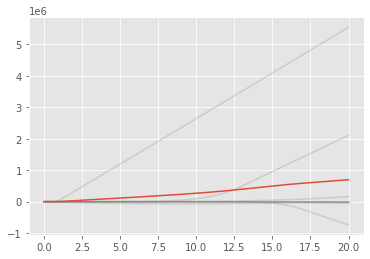

In [39]:

fig, ax = plt.subplots()
# alpha = [0.5, 0.8, 0.95, 0.995]
# for i, a in enumerate(reversed(sorted(alpha))):
#     a2 = (1 - a) / 2
#     ax.fill_between(all_t, y1=np.quantile(theta_sims, a2, axis=1), y2=np.quantile(theta_sims, 1 - a2, axis=1), alpha=0.25 * (i + 1), color="gray", label=alpha)
for i in range(nsims):
    ax.plot(all_t, theta_sims[:, i], label="", c="gray", alpha=0.25)
ax.plot(all_t, theta_sims.mean(axis=1), label="mean")
plt.show()


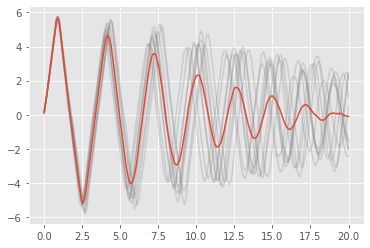

In [16]:

fig, ax = plt.subplots()
# alpha = [0.5, 0.8, 0.95, 0.995]
# for i, a in enumerate(reversed(sorted(alpha))):
#     a2 = (1 - a) / 2
#     ax.fill_between(all_t, y1=np.quantile(theta_sims, a2, axis=1), y2=np.quantile(theta_sims, 1 - a2, axis=1), alpha=0.25 * (i + 1), color="gray", label=alpha)
for i in range(nsims):
    ax.plot(all_t, theta_d_sims[:, i], label="", c="gray", alpha=0.25)
ax.plot(all_t, theta_d_sims.mean(axis=1), label="mean")
plt.show()


In [134]:
qr.models[0.5].feature_importances_

array([703, 891, 485, 675])

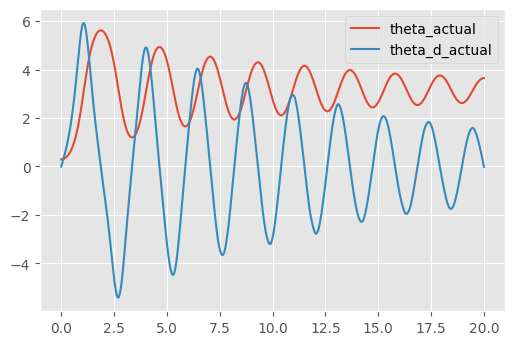

In [133]:
all_t = np.linspace(*tspan, 1000)
fig, ax = plt.subplots(dpi=100)
pd.DataFrame(
    res.sol(all_t).T, index=all_t, columns=["theta_actual", "theta_d_actual"]
).plot(ax=ax)

plt.show()


In [ ]:
  
qr = QuantileRegressor(LGBMRegressor(), [0.2, 0.5, 0.8])
y = np.linspace(0, 1, 101)
x = np.zeros(len(y))
for i in range(len(y)):
    x[i]=qr.np_sample_from_quantiles([2 ,3, 6], y[i])
plt.plot(x,y)
